In [1]:
%load_ext autotime

time: 219 µs (started: 2022-06-29 13:53:18 +08:00)


In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

time: 1.57 s (started: 2022-06-29 13:53:18 +08:00)


In [3]:
from matplotlib.backends.backend_pdf import PdfPages

time: 73.5 ms (started: 2022-06-29 13:53:20 +08:00)


In [4]:
pd.set_option('display.max_rows', 200, 'display.max_columns', None)

time: 193 µs (started: 2022-06-29 13:53:20 +08:00)


In [5]:
all_rows = pd.option_context("display.max_rows", None)

time: 153 µs (started: 2022-06-29 13:53:20 +08:00)


In [6]:
months = pd.Series({m: i for i, m in enumerate("FGHJKMNQUVXZ")})

time: 2.11 ms (started: 2022-06-29 13:53:20 +08:00)


In [7]:
parquet_data = Path("csi_data.parquet")
if not parquet_data.exists():
    dailies_csv = pd.read_csv(
        "csi_data.csv.gz", 
        names=['contract', 'expiry', 'date', 
               'open', 'high', 'low', 'close', 
               'volume', 'open_interest'],
        parse_dates=["date"],
    )

    # Adjust for multiplier inconsistencies in old data
    for contract, mult in [
        ("SXE", 1/10), ("SXX", 1/10), 
        ("CU", 10), ("JY", 10), ("CD", 10),
    ]:
        dailies_csv.loc[
            lambda df: (
            (df.contract == contract) & 
            (df.date < "2008")
            ), "close"
        ] *= mult
    dailies_csv.to_parquet(parquet_data)

time: 566 µs (started: 2022-06-29 13:53:20 +08:00)


In [8]:
dailies = pd.read_parquet("csi_data.parquet")

time: 5.46 s (started: 2022-06-29 13:53:20 +08:00)


In [9]:
prev_close = dailies.sort_values("date").groupby(["contract", "expiry"]).close.shift()
dailies["d_close"] = dailies["close"] - prev_close

time: 29.1 s (started: 2022-06-29 13:53:25 +08:00)


In [10]:
dailies["expiry_int"] = (
    dailies["expiry"].str.slice(0, 4).astype(int) * 12 + 
    dailies["expiry"].str.slice(4, 5).map(months)
)

time: 29.7 s (started: 2022-06-29 13:53:54 +08:00)


In [11]:
dailies["mod_month"] = dailies.eval(
    "expiry_int - (date.dt.year + (expiry_int.mod(12) < date.dt.month.sub(1))) * 12"
)

time: 4.91 s (started: 2022-06-29 13:54:24 +08:00)


In [12]:
dailies[["expiry_int", "mod_month"]] = dailies[["expiry_int", "mod_month"]].astype("Int64")

time: 17.5 s (started: 2022-06-29 13:54:29 +08:00)


In [13]:
dailies = dailies.query("mod_month.between(0, 11)").copy()

time: 7.26 s (started: 2022-06-29 13:54:46 +08:00)


In [14]:
dailies["mod_month"] = pd.Categorical.from_codes(dailies["mod_month"], months.index)

time: 69.6 ms (started: 2022-06-29 13:54:54 +08:00)


In [15]:
metadata = (
    pd.read_csv("contracts.csv")
    .dropna(subset=["Exch Symbol", "Currency", "Name", "Point Value", 
                    "Symbol", 'Futures Category'])
    .set_index("Symbol")
)

time: 21.7 ms (started: 2022-06-29 13:54:54 +08:00)


In [16]:
names = metadata["Name"].str.lower()
point_values = metadata["Point Value"].str.lower()

time: 1.26 ms (started: 2022-06-29 13:54:54 +08:00)


In [17]:
contract_mask = (
    metadata.Currency.isin(["USD", "EUR"])
    &
    ~point_values.str.contains("contract")
    &
    ~point_values.str.contains("mwh")    
    &
    ~names.index.isin(["TF", "ER2", "SP2", "ZI"])
    &
    (
        names.str.contains("combined session")
        |
        ~names.str.contains("session")
    )
    &
    ~names.str.contains("divided by 10")
    &
    ~names.str.contains("last in")
    &
    ~names.str.contains("last trade in close")  
    &
    ~names.str.contains("floor trading only")
    &
    ~names.str.contains("\(floor\)")    
)

time: 10.1 ms (started: 2022-06-29 13:54:54 +08:00)


In [18]:
multiplier = (
    point_values
    .loc[
        lambda df: (
            df.str.match("(usd|eur|\$|\d)")
            |
            df.str.contains("us dollar")
        )
    ]
    .str.extract("(\d+(?:[.]\d*)?|[.]\d+)", expand=False).astype(float)
    .rename("multiplier")
)
metadata["multiplier"] = multiplier

time: 9.1 ms (started: 2022-06-29 13:54:54 +08:00)


In [19]:
dailies = dailies.loc[lambda df: df.contract.map(contract_mask).fillna(False)]

time: 4 s (started: 2022-06-29 13:54:54 +08:00)


In [20]:
contract_volumes = (
    dailies
    .assign(decade=lambda df: df.eval("date.dt.year.floordiv(10).mul(10)"))
    .assign(adr=lambda df: df.eval("high - low"))
    .groupby(["contract", "decade"])
    .agg({"volume": "mean", "adr": "mean"})
    .reset_index()
)

time: 2.06 s (started: 2022-06-29 13:54:58 +08:00)


In [21]:
contract_volumes["multiplier"] = contract_volumes.contract.map(metadata.multiplier)
contract_volumes["currency"] = contract_volumes.contract.map(metadata.Currency)
contract_volumes["category"] = contract_volumes.contract.map(metadata['Futures Category'])
contract_volumes["exchange"] = contract_volumes.contract.map(metadata.Exchange)
contract_volumes["exch_symbol"] = contract_volumes.contract.map(metadata['Exch Symbol'])
contract_volumes["name"] = contract_volumes.contract.map(metadata['Name'])
contract_volumes["dollar_vol"] = contract_volumes.eval("adr * multiplier * volume")
contract_volumes["cat_rank"] = (
    contract_volumes.groupby(["category", "decade"])
    .dollar_vol.rank(ascending=False)
    .astype(int)
)
contract_volumes["start_year"] = contract_volumes.contract.map(
    dailies.groupby("contract").date.min().dt.year.astype("Int64")
)

time: 337 ms (started: 2022-06-29 13:55:00 +08:00)


In [22]:
shortlist = (
    contract_volumes    
    .query("cat_rank <= 6 & start_year < 2000 & decade == 2010")
    .query("dollar_vol.rank(ascending=False) <= 50")
    .sort_values("dollar_vol", ascending=False)
    [["dollar_vol", "currency", "contract", "exchange", "exch_symbol",
      "category", "cat_rank", "name", "start_year"]]
    .reset_index(drop=True)
)
with all_rows:
    display(
        shortlist
        .style
        .format(subset=["dollar_vol"], formatter="{:.1e}")
        .set_properties(subset=["name"], **{'white-space': 'pre-wrap'})
    )

,dollar_vol,currency,contract,exchange,exch_symbol,category,cat_rank,name,start_year
0,4.2e+08,USD,ES,CME,ES,Indexes-U.S.,1,e-mini S&P 500 Index-CME,1982
1,3.2e+08,USD,US,CBT,ZB,Govt Bonds,1,U.S. T-Bond (Floor+Electronic Combined)-CBT,1977
2,1.8e+08,USD,TY,CBT,TYF,Govt Notes,1,10-Year U.S. T-Note (Floor+Electronic Combined)-CBT,1982
3,1.7e+08,EUR,SXE,EUREX,FESX,Indexes-European,1,Euro STOXX 50 Index-EUREX,1998
4,1.2e+08,EUR,FDX,EUREX,FDAX,Indexes-European,2,DAX Index-EUREX,1990
5,1.2e+08,EUR,EBL,EUREX,FGBL,Govt Bonds,2,Euro German Bund-EUREX,1990
6,1.1e+08,USD,CL2,NYMEX,YC,Energy,1,Crude Oil (Floor+Electronic Combined)-NYMEX,1983
7,9.8e+07,USD,FV,CBT,FV,Govt Notes,2,5-Year U.S. T-Note (Floor+Electronic Combined)-CBT,1988
8,9.0e+07,USD,LCO,ICE,B,Energy,2,Brent Crude (Combined)-(IPE),1988
9,6.5e+07,USD,CU,CME,Y2,FOREX,1,Euro (Floor+Electronic Combined)-CME,1976


time: 59 ms (started: 2022-06-29 13:55:00 +08:00)


In [23]:
top_ratio = (
    dailies
    .query("date > '2008'")
    .sort_values("volume")
    .groupby(["contract", "date"]).last()
    .groupby(["contract", "mod_month"]).volume.count()
)
top_ratio /= top_ratio.groupby("contract").transform("max")

time: 24 s (started: 2022-06-29 13:55:00 +08:00)


In [24]:
with PdfPages('expiry_volumes.pdf') as pdf:
    for contract_rank in tqdm(shortlist.index):

        title = "{contract_rank} - {contract} / {exch_symbol}({exchange}) / {name}".format(
            contract_rank=contract_rank, **shortlist.loc[contract_rank].to_dict()
        )

        plt.figure(dpi=100)

        ax = (
            top_ratio
            .loc[shortlist.contract[contract_rank]]
            .plot.bar(figsize=(8, 5), title=title)
        )
        
        ax.axhline(y=1/12, color="red")
        
        pdf.savefig()
        plt.close()        

  0%|          | 0/50 [00:00<?, ?it/s]

time: 2.58 s (started: 2022-06-29 13:55:24 +08:00)


In [25]:
active_months = top_ratio[top_ratio > 1/12].reset_index().drop("volume", axis=1)
dailies = dailies.merge(active_months)

time: 1.16 s (started: 2022-06-29 13:55:27 +08:00)


In [26]:
volumes = dailies.set_index(["contract", "date", "expiry"]).volume.loc[lambda xs: xs > 0]
volumes /= volumes.groupby(["contract", "date"]).transform("sum")
volumes = volumes.sort_index().rename("volume_fraction")
volumes = volumes.groupby(["contract", "expiry"]).shift()

time: 2.75 s (started: 2022-06-29 13:55:28 +08:00)


In [27]:
live_contracts = (
    volumes
    .loc[lambda df: df.groupby(["contract", "expiry"]).cummax().gt(1/3)]
    .reset_index()
)

time: 288 ms (started: 2022-06-29 13:55:31 +08:00)


In [28]:
live_contracts = live_contracts.merge(dailies, how="left")

time: 2.97 s (started: 2022-06-29 13:55:31 +08:00)


In [29]:
front = (
    live_contracts
    .sort_values("expiry")
    .groupby(["contract", "date"]).first()
)

time: 27.6 s (started: 2022-06-29 13:55:34 +08:00)


In [30]:
front["vol"] = (
    front
    .d_close.abs()
    .groupby("contract").rolling(180).mean()
    .reset_index(level=0, drop=True)
    .groupby("contract").shift()
)

time: 193 ms (started: 2022-06-29 13:56:02 +08:00)


In [31]:
dollar_vol2 = front["vol"].groupby("contract").last().mul(metadata.multiplier).dropna()

time: 22.6 ms (started: 2022-06-29 13:56:02 +08:00)


In [32]:
50**0.5 * 10 * 100 * 1700

12020815.280171309

time: 1.19 ms (started: 2022-06-29 13:56:02 +08:00)


In [33]:
shortlist_sizing = (
    shortlist
    .assign(dollar_vol2=lambda df: df.contract.map(dollar_vol2))
    .assign(dollar_tick=lambda df: df.contract.map(metadata.eval("MinTick * multiplier")))
    .assign(vol_ticks=lambda df: df.eval("dollar_vol2 / dollar_tick"))
    [["dollar_vol2", "dollar_tick", "vol_ticks", "currency", "contract", "exchange", "exch_symbol",
      "category", "cat_rank", "name", "start_year"]]
    .sort_values("dollar_vol2", ascending=False)
)
with all_rows:
    display(
        shortlist_sizing
        .style
        .format(subset=["dollar_vol2"], formatter="{:,.0f}")
        .format(subset=["vol_ticks", "dollar_tick"], formatter="{:,.1f}")
        .set_properties(subset=["name"], **{'white-space': 'pre-wrap'})
    )

,dollar_vol2,dollar_tick,vol_ticks,currency,contract,exchange,exch_symbol,category,cat_rank,name,start_year
1,"1,656",15.6,106.0,USD,US,CBT,ZB,Govt Bonds,1,U.S. T-Bond (Floor+Electronic Combined)-CBT,1977
4,"1,589",12.5,127.1,EUR,FDX,EUREX,FDAX,Indexes-European,2,DAX Index-EUREX,1990
18,945,4.2,224.9,USD,RB2,NYMEX,RB,Energy,5,Gasoline-Reformulated Blendstock(Combined)-NYMEX,1984
20,792,4.2,188.7,USD,HO2,NYMEX,HO,Energy,6,NY Harbor ULSD (Floor+Electronic Combined)-NYMEX,1978
39,779,10.0,77.9,USD,EMD,CME,EMD,Indexes-U.S.,6,e-mini S&P Midcap 400 Index-CME,1992
31,714,20.0,35.7,EUR,EBX,EUREX,FGBX,Govt Notes,5,Euro Buxl (4%)-EUREX,1998
21,689,5.0,137.8,USD,SI2,COMEX,YV,Metals,2,Silver (Floor+Electronic Combined)-COMEX,1976
47,688,12.5,55.0,USD,FC,CME,D2,Livestock & Meats,3,Feeder Cattle (Floor+Electronic Combined)-CME,1976
8,627,10.0,62.7,USD,LCO,ICE,B,Energy,2,Brent Crude (Combined)-(IPE),1988
10,626,10.0,62.6,USD,GC2,COMEX,YG,Metals,1,Gold (Floor+Electronic Combined)-COMEX,1976


time: 15.9 ms (started: 2022-06-29 13:56:02 +08:00)


In [34]:
with PdfPages('prices.pdf') as pdf:
    for contract in tqdm(shortlist.itertuples(), total=len(shortlist)):
        title = (f"{contract.Index} - {contract.contract} / "
                 f"{contract.exch_symbol}({contract.exchange}) / {contract.name}")
        plt.figure(dpi=100)

        (
            front.loc[contract.contract]
            .eval("d_close / vol").cumsum()
            .plot(figsize=(8, 5), title=title)
        )
        
        pdf.savefig()
        plt.close()        

  0%|          | 0/50 [00:00<?, ?it/s]

time: 3.32 s (started: 2022-06-29 13:56:02 +08:00)


In [44]:
ndays = 180
signal = (
    front
    .eval("d_close / vol")
    .groupby("contract").cumsum()
    .pipe(lambda xs: (
        xs.groupby("contract").rolling(ndays).mean().reset_index(level=0, drop=True)
        .lt(xs)
    ))
    .groupby("contract").shift(fill_value=False)
    .groupby("contract").rolling(ndays).mean().reset_index(level=0, drop=True)
)

time: 351 ms (started: 2022-06-29 14:00:48 +08:00)


In [45]:
with PdfPages('signals.pdf') as pdf:
    for contract in tqdm(shortlist.itertuples(), total=len(shortlist)):
        title = (f"{contract.Index} - {contract.contract} / "
                 f"{contract.exch_symbol}({contract.exchange}) / {contract.name}")
        plt.figure(dpi=100)

        (
            signal.loc[contract.contract]
            .plot(figsize=(8, 5), title=title)
        )
        
        pdf.savefig()
        plt.close()        

  0%|          | 0/50 [00:00<?, ?it/s]

time: 2.67 s (started: 2022-06-29 14:00:49 +08:00)


In [46]:
rets = front.eval("d_close / vol * @signal")
start_year = "1980"

time: 125 ms (started: 2022-06-29 14:00:54 +08:00)


In [47]:
pnl = rets.loc[shortlist.contract].groupby("date").sum()[start_year:]

time: 113 ms (started: 2022-06-29 14:00:54 +08:00)


In [75]:
with PdfPages('returns.pdf') as pdf:
    
    c_pl = pnl.cumsum()
    plt.figure(figsize=(8, 5), dpi=100)
    c_pl.plot(lw=1, color="black", title="Portfolio")
    plt.ylabel("Cumulative points")
    plt.fill_between(c_pl.index, c_pl, c_pl.cummax(), facecolor='red', alpha=0.5);
    
    ax = (
        front.loc[shortlist.contract]
        .groupby("date").expiry.count()
        .cummax()
        .plot(secondary_y=True)
    )
    ax.set_ylabel("Contract Count", rotation=-90, labelpad=20)
    ax.set_ylim(0, None)

    pdf.savefig()
    plt.close()
    
    for contract in tqdm(shortlist.itertuples(), total=len(shortlist)):
        title = (f"{contract.Index} - {contract.contract} / "
                 f"{contract.exch_symbol}({contract.exchange}) / {contract.name}")
        plt.figure(dpi=100)

        (
            rets.loc[contract.contract]
            .cumsum().plot(figsize=(8, 5), title=title, xlim=(pnl.index[0], pnl.index[-1]))
        )
        
        pdf.savefig()
        plt.close()

  0%|          | 0/50 [00:00<?, ?it/s]

time: 3.36 s (started: 2022-06-29 14:25:14 +08:00)


In [49]:
decade = (pnl.index.get_level_values("date").year // 10) * 10
by_period = {}
legend = []
for _, pnl0 in pnl.groupby(decade):
    yr0 = pnl0.index.year[0]
    pnl0.index = ((pnl0.index - pd.Timestamp(yr0, 1, 1)) / pd.Timedelta(days=1)).astype(int)
    by_period[yr0] = pnl0
by_period = pd.DataFrame(by_period)

time: 750 µs (started: 2022-06-29 14:00:57 +08:00)


<AxesSubplot:xlabel='date'>

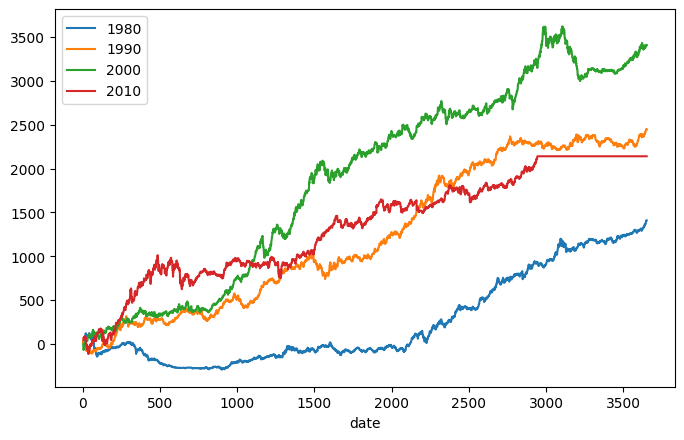

time: 99.1 ms (started: 2022-06-29 14:00:57 +08:00)


In [51]:
plt.figure(figsize=(8, 5), dpi=100)
by_period.cumsum().fillna(method="ffill").plot(ax=plt.gca())

In [52]:
by_period.apply(lambda xs: xs.mean() / xs.std() * 250**0.5)

1980    1.025464
1990    1.380073
2000    1.316695
2010    1.052091
dtype: float64

time: 3.08 ms (started: 2022-06-29 14:00:58 +08:00)
